In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve

In [53]:
label = 'lymphocyte'

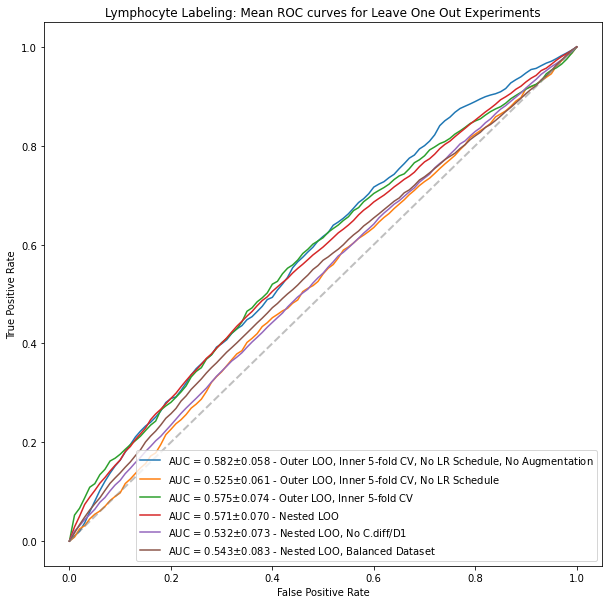

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
labels = [
    ('loo_nolr', 'Outer LOO, Inner 5-fold CV, No LR Schedule, No Augmentation'),
    ('loo_nolr_aug', 'Outer LOO, Inner 5-fold CV, No LR Schedule'),
    ('loo', 'Outer LOO, Inner 5-fold CV'),
    ('nloo', 'Nested LOO'),
    ('nloo_noD1', 'Nested LOO, No C.diff/D1'),
    ('nloo_balance', 'Nested LOO, Balanced Dataset'),
]
for k, label in labels:
    (mean_fpr, mean_tpr), (mean_auc, std_auc) = mean_fprs_tprs[k]
    plt.plot(mean_fpr, mean_tpr, label=f'AUC = {mean_auc:0.3f}$\pm${std_auc:0.3f} - {label}')

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.5)
ax.legend(loc='lower right')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('Lymphocyte Labeling: Mean ROC curves for Leave One Out Experiments')
plt.savefig('leave-one-out-rocs.png')

# Per sample count

In [144]:
counts = defaultdict(dict)
for path, dirs, files in os.walk('/mnt/data5/output/tiles/gi-infection'):
    _, slide, section = path.rsplit('/', 2)
    sample = f'{slide}/{section}'
    for file in files:
        if file == f'{label}.csv':
            df = pd.read_csv(os.path.join(path, file))
            T = ((df['CD3E'] > 0) & (df['PTPRC'] > 0))
            B = ((df['MS4A1'] > 0) & (df['PTPRC'] > 0))
            plasma = ((df['SDC1'] > 2) & (df['PTPRC'] > 0))
            lymphocyte = (T | B | plasma)
            counts[sample]['T'] = T.sum()
            counts[sample]['B'] = B.sum()
            counts[sample]['Plasma'] = plasma.sum()
            counts[sample]['Lymphocyte'] = lymphocyte.sum()
            counts[sample]['Total'] = len(df)

df = pd.DataFrame(index=pd.MultiIndex.from_tuples([], names=['Slide', 'Section']))
for sample, c in counts.items():
    slide, section = sample.split('/')
    c = pd.Series(c)
    df.loc[(slide, section), c.index] = c
df = df.sort_index()
df.columns.name = 'Spot Count'
sums = df.sum(axis=0)
df.loc[('Total',''), sums.index] = sums
df = df.round().astype(int)
df['Frac'] = df['Lymphocyte'] / df['Total']

In [146]:
df.to_csv(f'{label}_per_sample_count.csv')

# Per split count

In [152]:
test = pd.read_csv('/mnt/data5/output/train/lymphocyte/00/test.csv')
val = pd.read_csv('/mnt/data5/output/train/lymphocyte/00/val.csv')
train = pd.read_csv('/mnt/data5/output/train/lymphocyte/00/train.csv')

In [158]:
for temp in [train, val, test, pd.concat([train, val, test])]:
    pos = temp[label].sum()
    n = len(temp)
    frac = pos/n
    print(f'{pos}/{n} ({frac:0.2f})')

1644/6469 (0.25)
469/1847 (0.25)
235/923 (0.25)
2348/9239 (0.25)


# Plot functions

In [34]:
def plot_roc_curve(y_trues, y_preds, title, filename, names=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 101)
    for y_true, y_pred in zip(y_trues, y_preds):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1
    std_tpr = np.std(tprs, axis=0)

    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.5)
    ax.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:0.3f} $\pm$ {std_auc:0.3f})')
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label=f'$\pm$ 1 std. dev.')
    if names is not None:
        for name, tpr, _auc in zip(names, tprs, aucs):
            ax.plot(mean_fpr, tpr, label=f'{name} (AUC = {_auc:0.3f})')

    ax.legend(loc='lower right')
    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(title)

    plt.savefig(filename)
    plt.show()

    return aucs, (mean_fpr, mean_tpr), (mean_auc, std_auc)

In [4]:
def plot_calibration_curve(y_trues, y_preds, title, filename):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,10))

    briers = []
    for y_true, y_pred in zip(y_trues, y_preds):
        briers.append(brier_score_loss(y_true, y_pred))
    y_true = np.concatenate(y_trues)
    y_pred = np.concatenate(y_preds)
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy='uniform')
    mean_brier = np.mean(briers)
    std_brier = np.std(briers)

    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.5)
    ax1.plot(prob_pred, prob_true, '-o', label=f'Brier score {mean_brier:0.3f} $\pm$ {std_brier:0.3f}')
    ax1.legend(loc='lower right')
    ax1.set_xlim([-0.05,1.05])
    ax1.set_ylim([-0.05,1.05])
    ax1.set_xlabel("Predicted Probability")
    ax1.set_ylabel("True Probability")
    ax1.set_title(title)

    ax2.hist(y_pred)
    ax2.set_xlim([-0.05,1.05])
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Count')

    plt.savefig(filename)
    plt.show()

In [5]:
def plot_training_history(trials, train_dir, filename, ylim=[0.4,0.6]):
    l = int(round(np.sqrt(trials)))
    fig, axs = plt.subplots(l, l, figsize=(l*2,l*2))
    for i in range(l):
        for j in range(l):
            trial = j + i * l
            if int(trial) >= trials:
                break
            trial = f'{trial:02d}'
            hist = pd.read_csv(f'{train_dir}/{trial}/training_history.csv')
            ax = axs[i, j]
            ax.plot(hist['loss'])
            ax.plot(hist['val_loss'])
            ax.set(
                ylim=ylim,
            )
        if int(trial) >= trials:
            break

    plt.savefig(filename)
    plt.show()

In [12]:
from scipy.stats import ttest_ind

In [13]:
ttest_ind(aucs_loo, aucs_loo_nolr)

Ttest_indResult(statistic=-0.1832389834122674, pvalue=0.8572377507826388)

In [14]:
ttest_ind(aucs_loo_nolr, aucs_loo_nolr_aug)

Ttest_indResult(statistic=1.7942585804556983, pvalue=0.0943889345890418)

In [15]:
ttest_ind(aucs_loo_nolr_aug, aucs_nloo)

Ttest_indResult(statistic=-1.7473846189566062, pvalue=0.0855220140860628)

In [16]:
ttest_ind(aucs_nloo, aucs_nloo_nod1)

Ttest_indResult(statistic=2.6598094928871143, pvalue=0.009162882510269423)

In [11]:
aucs_loo
aucs_loo_nolr
aucs_loo_nolr_aug
aucs_nloo
aucs_nloo_nod1

[0.6039586919104992,
 0.6038491628853075,
 0.6184008762322015,
 0.5062588014395243,
 0.607432326709435,
 0.5805038335158816,
 0.6292876766091052,
 0.3710753532182103,
 0.505540293040293,
 0.43585164835164836,
 0.37766875981161696,
 0.507554945054945,
 0.5719342564870258,
 0.43294660678642716,
 0.6752588572854291,
 0.5309108345808383,
 0.5613304640718563,
 0.38479681262475046,
 0.5381415698054068,
 0.5234164816507771,
 0.6490858038396238,
 0.534008097165992,
 0.4700078359670889,
 0.4859736189108006,
 0.5444105552023563,
 0.5361376457617435,
 0.4818808797611479,
 0.4776880919999034,
 0.4507287081224197,
 0.5862096715783713,
 0.6292531192437354,
 0.5589615264310291,
 0.6285232683418482,
 0.4951169499183262,
 0.5680325304973413,
 0.4495707781600807,
 0.4673162801995553,
 0.5414656477138959,
 0.5243633102262748,
 0.5266989293521926,
 0.5730964704123769,
 0.592811898578075]

In [21]:
mean_fprs_tprs = {}

# Nested Leave One Out, H. pylori only

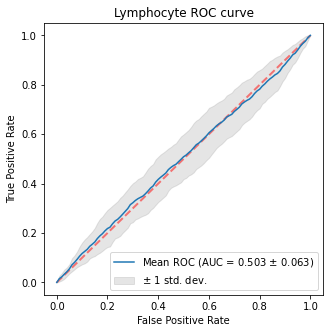

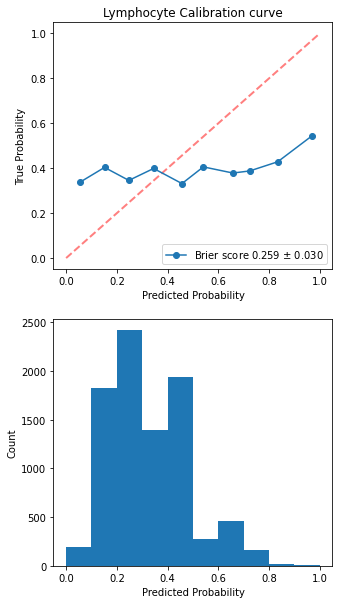

In [54]:
y_trues = []
y_preds = []
names = []
samples = [f'{slide}.{section}' for slide in ['H.pylori'] for section in ['A1', 'B1', 'C1', 'D1'] if f'{slide}.{section}' != 'C.diff.D1']
for test_sample in samples:
    for val_sample in samples:
        if test_sample == val_sample:
            continue
        y_true = pd.read_csv(f'/mnt/data5/output/train/nested-leave-one-out-hpylori/{test_sample}/{val_sample}/test.csv')[label]
        y_pred = pd.read_csv(f'/mnt/data5/output/train/nested-leave-one-out-hpylori/{test_sample}/{val_sample}/test_predictions.csv')[label]
        y_trues.append(y_true)
        y_preds.append(y_pred)
        # names.append(f'{slide}/{section}')

aucs_nloo_hp, mean_fpr, mean_tpr = plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'scaled-roc.png')
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'scaled-calibration.png')
# plot_training_history(25, f'/mnt/data5/output/train/{label}-scaled-tiles', 'scaled-history.png')

mean_fprs_tprs['nloo_hp'] = (mean_fpr, mean_tpr)

# Nested Leave One Out, Augment, Early Stopping, Balanced Labels
outer: leave one out  
inner: leave one out  
lr schedule: initial lr = 0.01, scale by 0.1 if no improvement to val loss for 5 epochs, early stop if no improvement for 15 epochs  
augmentation: rotate by 0, 90, 180, 270 deg w uniform probability, flip vertical or horizontally w .25 probably for either  
classes resampled to 1:1  
56 final models


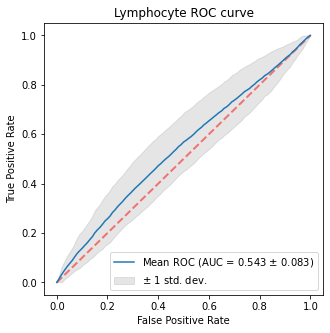

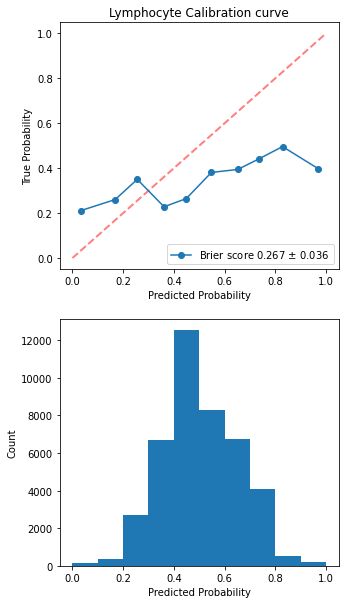

In [38]:
y_trues = []
y_preds = []
names = []
samples = [f'{slide}.{section}' for slide in ['H.pylori', 'C.diff'] for section in ['A1', 'B1', 'C1', 'D1'] if f'{slide}.{section}' != 'C.diff.D1']
for test_sample in samples:
    for val_sample in samples:
        if test_sample == val_sample:
            continue
        y_true = pd.read_csv(f'/mnt/data5/output/train/nested-leave-one-out-balanced/{test_sample}/{val_sample}/test.csv')[label]
        y_pred = pd.read_csv(f'/mnt/data5/output/train/nested-leave-one-out-balanced/{test_sample}/{val_sample}/test_predictions.csv')[label]
        y_trues.append(y_true)
        y_preds.append(y_pred)
        # names.append(f'{slide}/{section}')

aucs_nloo_balance, mean_fpr, mean_tpr = plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'scaled-roc.png')
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'scaled-calibration.png')
# plot_training_history(25, f'/mnt/data5/output/train/{label}-scaled-tiles', 'scaled-history.png')

mean_fprs_tprs['nloo_balance'] = (mean_fpr, mean_tpr)

# Nested Leave One Out, Augment, Early Stopping, Skip C.diff/D1
outer: leave one out  
inner: leave one out  
lr schedule: initial lr = 0.01, scale by 0.1 if no improvement to val loss for 5 epochs, early stop if no improvement for 15 epochs  
augmentation: rotate by 0, 90, 180, 270 deg w uniform probability, flip vertical or horizontally w .25 probably for either  
#### skip C.diff/D1  
42 final models

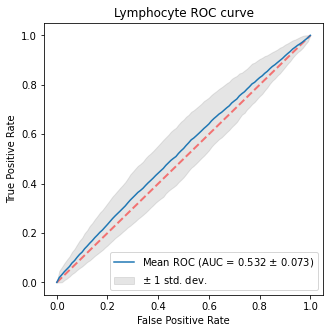

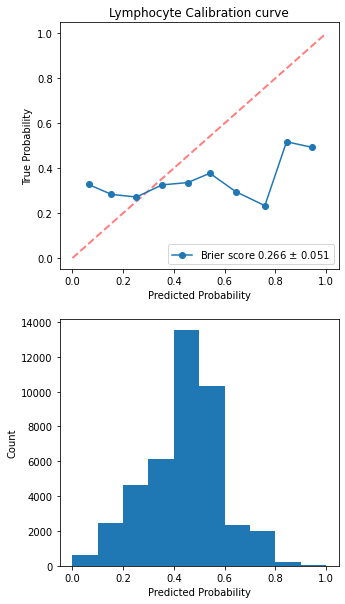

In [39]:
y_trues = []
y_preds = []
names = []
samples = [f'{slide}.{section}' for slide in ['H.pylori', 'C.diff'] for section in ['A1', 'B1', 'C1', 'D1'] if f'{slide}.{section}' != 'C.diff.D1']
for test_sample in samples:
    for val_sample in samples:
        if test_sample == val_sample:
            continue
        y_true = pd.read_csv(f'/mnt/data5/output/train/nested-leave-one-out-2/{test_sample}/{val_sample}/test.csv')[label]
        y_pred = pd.read_csv(f'/mnt/data5/output/train/nested-leave-one-out-2/{test_sample}/{val_sample}/test_predictions.csv')[label]
        y_trues.append(y_true)
        y_preds.append(y_pred)
        # names.append(f'{slide}/{section}')

aucs_nloo_nod1, mean_fpr, mean_tpr = plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'scaled-roc.png')
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'scaled-calibration.png')
# plot_training_history(25, f'/mnt/data5/output/train/{label}-scaled-tiles', 'scaled-history.png')
mean_fprs_tprs['nloo_noD1'] = (mean_fpr, mean_tpr)

# Nested Leave One Out, Augment, Early Stopping
outer: leave one out  
inner: leave one out  
lr schedule: initial lr = 0.01, scale by 0.1 if no improvement to val loss for 5 epochs, early stop if no improvement for 15 epochs  
augmentation: rotate by 0, 90, 180, 270 deg w uniform probability, flip vertical or horizontally w .25 probably for either  
56 final models

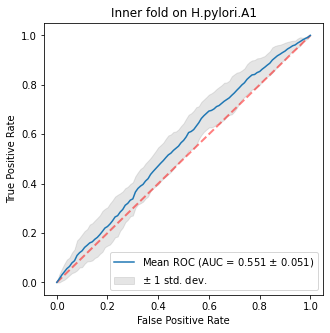

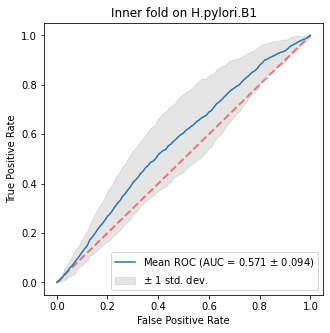

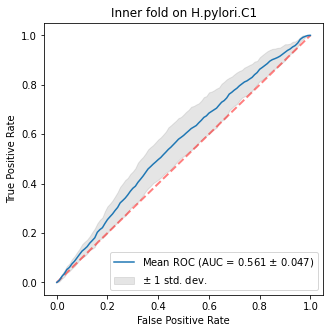

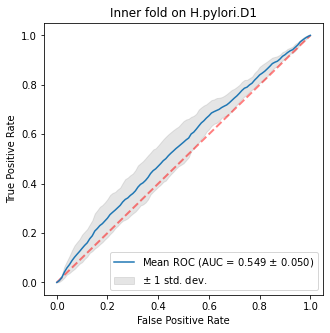

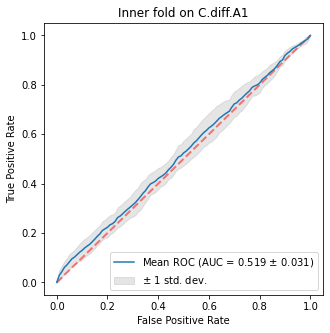

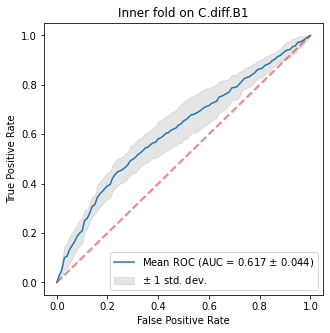

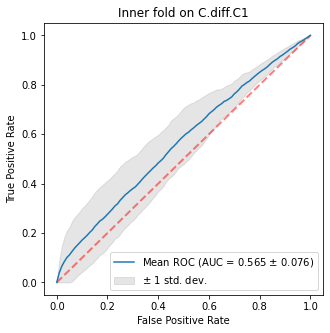

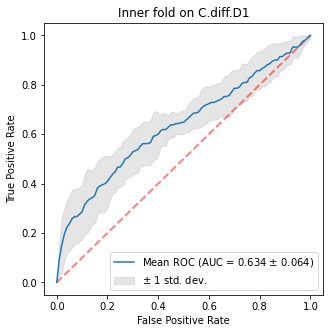

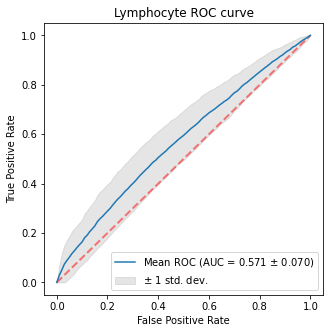

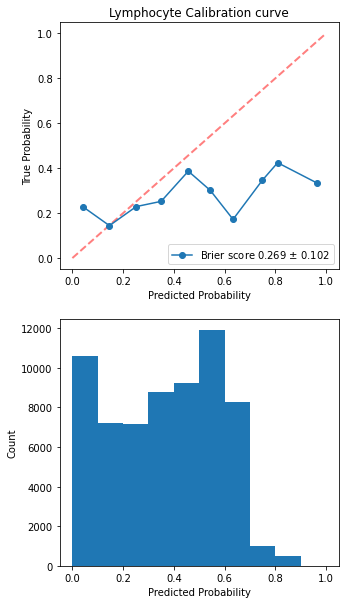

In [40]:
y_trues = []
y_preds = []
names = []
samples = [f'{slide}.{section}' for slide in ['H.pylori', 'C.diff'] for section in ['A1', 'B1', 'C1', 'D1']]
for test_sample in samples:
    per_test_trues = []
    per_test_preds = []
    for val_sample in samples:
        if test_sample == val_sample:
            continue
        y_true = pd.read_csv(f'/mnt/data5/output/train/nested-leave-one-out/{test_sample}/{val_sample}/test.csv')[label]
        y_pred = pd.read_csv(f'/mnt/data5/output/train/nested-leave-one-out/{test_sample}/{val_sample}/test_predictions.csv')[label]
        y_trues.append(y_true)
        y_preds.append(y_pred)
        per_test_trues.append(y_true)
        per_test_preds.append(y_pred)
        # names.append(f'{slide}/{section}')
    plot_roc_curve(per_test_trues, per_test_preds, f'Inner fold on {test_sample}', 'temp-roc.png')

aucs_nloo, mean_fpr, mean_tpr = plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'scaled-roc.png')
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'scaled-calibration.png')
# plot_training_history(25, f'/mnt/data5/output/train/{label}-scaled-tiles', 'scaled-history.png')
mean_fprs_tprs['nloo'] = (mean_fpr, mean_tpr)

# Leave One Out Augment
outer: leave one out  
inner: 5-fold CV for finding best # of epochs, up to 100  
constant lr = 0.001  
augmentation: rotate by 0, 90, 180, 270 deg w uniform probability, flip vertical or horizontally w .25 probably for either  
8 final models

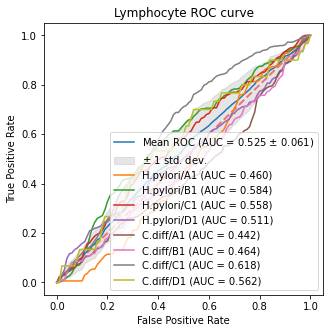

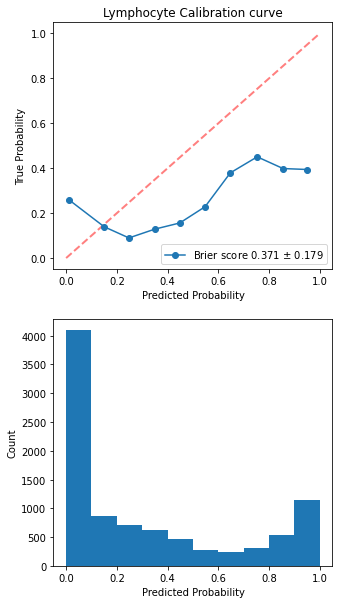

In [41]:
y_trues = []
y_preds = []
names = []
for slide in ['H.pylori', 'C.diff']:
    for section in ['A1', 'B1', 'C1', 'D1']:
        y_true = pd.read_csv(f'/mnt/data5/output/train/leave-one-out-augment/{slide}/{section}/test.csv')[label]
        y_pred = pd.read_csv(f'/mnt/data5/output/train/leave-one-out-augment/{slide}/{section}/test_predictions.csv')[label]
        y_trues.append(y_true)
        y_preds.append(y_pred)
        names.append(f'{slide}/{section}')

aucs_loo_nolr_aug, mean_fpr, mean_tpr = plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'scaled-roc.png', names)
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'scaled-calibration.png')
# plot_training_history(25, f'/mnt/data5/output/train/{label}-scaled-tiles', 'scaled-history.png')
mean_fprs_tprs['loo_nolr_aug'] = (mean_fpr, mean_tpr)

# Leave One Out No LR Schedule
outer: leave one out  
inner: 5-fold CV for finding best # of epochs, up to 100  
constant lr = 0.001  
no augmentation  
8 models

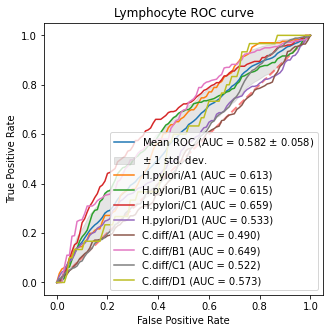

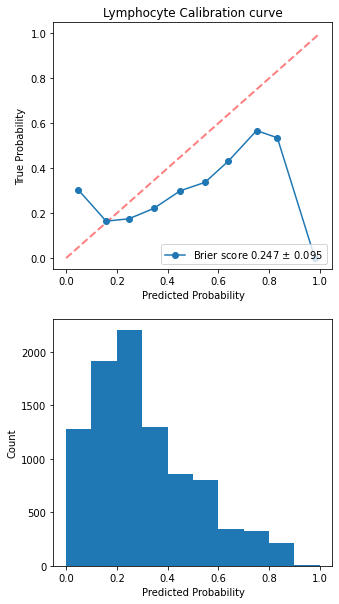

In [42]:
y_trues = []
y_preds = []
names = []
for slide in ['H.pylori', 'C.diff']:
    for section in ['A1', 'B1', 'C1', 'D1']:
        y_true = pd.read_csv(f'/mnt/data5/output/train/leave-one-out-2/{slide}/{section}/test.csv')[label]
        y_pred = pd.read_csv(f'/mnt/data5/output/train/leave-one-out-2/{slide}/{section}/test_predictions.csv')[label]
        y_trues.append(y_true)
        y_preds.append(y_pred)
        names.append(f'{slide}/{section}')

aucs_loo_nolr, mean_fpr, mean_tpr = plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'scaled-roc.png', names)
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'scaled-calibration.png')
# plot_training_history(25, f'/mnt/data5/output/train/{label}-scaled-tiles', 'scaled-history.png')
mean_fprs_tprs['loo_nolr'] = (mean_fpr, mean_tpr)

# Leave One Out
outer: leave one out  
inner: 5-fold CV for finding best # of epochs, up to 100  
lr schedule: initial lr = 0.01, scale by 0.1 every 20 epochs  
no augmentation  
8 final models

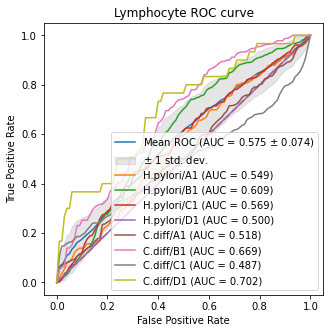

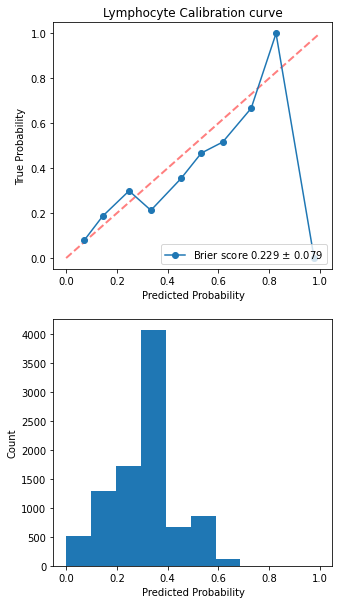

In [43]:
y_trues = []
y_preds = []
names = []
for slide in ['H.pylori', 'C.diff']:
    for section in ['A1', 'B1', 'C1', 'D1']:
        y_true = pd.read_csv(f'/mnt/data5/output/train/leave-one-out/{slide}/{section}/test.csv')[label]
        y_pred = pd.read_csv(f'/mnt/data5/output/train/leave-one-out/{slide}/{section}/test_predictions.csv')[label]
        y_trues.append(y_true)
        y_preds.append(y_pred)
        names.append(f'{slide}/{section}')

aucs_loo, mean_fpr, mean_tpr = plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'scaled-roc.png', names)
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'scaled-calibration.png')
# plot_training_history(25, f'/mnt/data5/output/train/{label}-scaled-tiles', 'scaled-history.png')
mean_fprs_tprs['loo'] = (mean_fpr, mean_tpr)

# Scaled

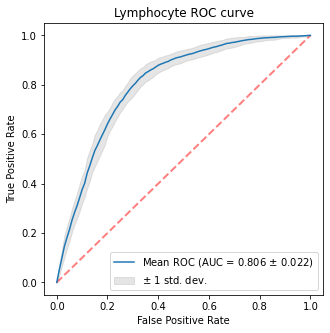

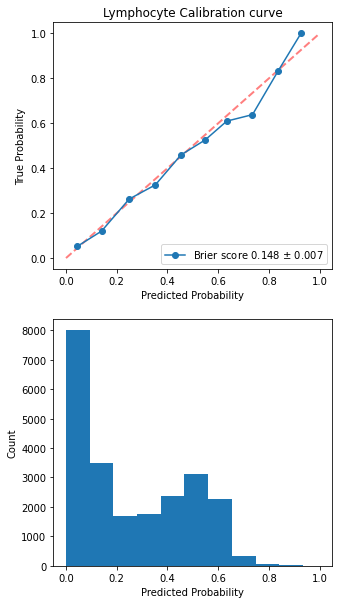

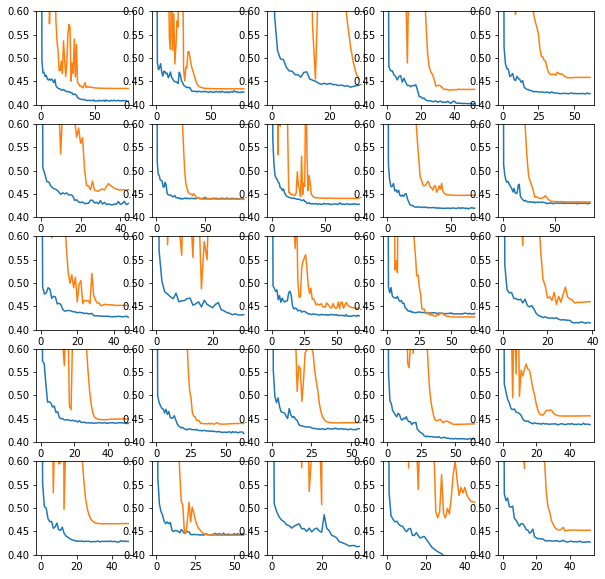

In [76]:
y_trues = []
y_preds = []
for i in range(25):
    i = f'{i:02d}'
    y_true = pd.read_csv(f'/mnt/data5/output/train/{label}-scaled-tiles/{i}/test.csv')[label]
    y_pred = pd.read_csv(f'/mnt/data5/output/train/{label}-scaled-tiles/{i}/test_predictions.csv')[label]
    y_trues.append(y_true)
    y_preds.append(y_pred)

plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'scaled-roc.png')
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'scaled-calibration.png')
plot_training_history(25, f'/mnt/data5/output/train/{label}-scaled-tiles', 'scaled-history.png')

# Padded

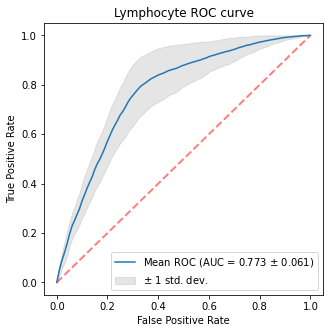

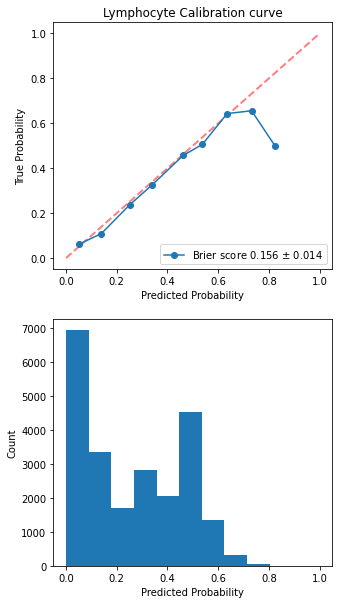

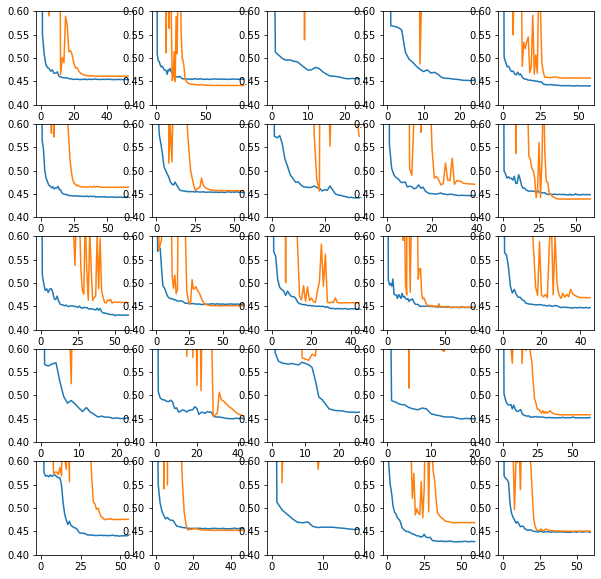

In [77]:
y_trues = []
y_preds = []
for i in range(25):
    i = f'{i:02d}'
    y_true = pd.read_csv(f'/mnt/data5/output/train/{label}-padded-tiles/{i}/test.csv')[label]
    y_pred = pd.read_csv(f'/mnt/data5/output/train/{label}-padded-tiles/{i}/test_predictions.csv')[label]
    y_trues.append(y_true)
    y_preds.append(y_pred)

plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', 'padded-roc.png')
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', 'padded-calibration.png')
plot_training_history(25, f'/mnt/data5/output/train/{label}-padded-tiles', 'padded-history.png')

In [ ]:
y_trues = []
y_preds = []
for i in range(25):
    i = f'{i:02d}'
    y_true = pd.read_csv(f'/mnt/data5/output/train/{label}-padded-tiles/{i}/test.csv')[label]
    y_pred = pd.read_csv(f'/mnt/data5/output/train/{label}-padded-tiles/{i}/test_predictions.csv')[label]
    y_trues.append(y_true)
    y_preds.append(y_pred)

# Overlapping Tiles

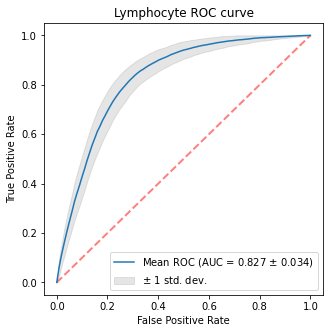

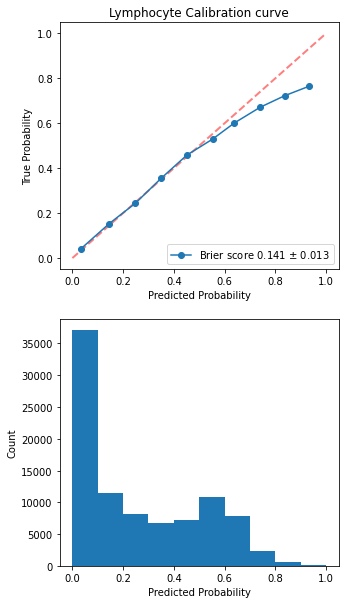

In [48]:
y_trues = []
y_preds = []
for i in range(100):
    i = f'{i:02d}'
    y_true = pd.read_csv(f'/mnt/data5/output/train/{label}/{i}/test.csv')[label]
    y_pred = pd.read_csv(f'/mnt/data5/output/train/{label}/{i}/test_predictions.csv')[label]
    y_trues.append(y_true)
    y_preds.append(y_pred)

plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve', f'{label}_roc_curve.png')
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve', f'{label}_calibration_curve.png')

# Predict on Cancer Dataset

In [35]:
from steml.utils import config_gpus
config_gpus({0: -1})

In [37]:
from steml.data import get_tile_paths_labels

paths, labels = get_tile_paths_labels(
    input_dir=f'/mnt/data5/output/tiles/gi-cancer',
    label=label,
)

In [38]:
from steml.data.dataset import make_dataset

ds = make_dataset(
    paths=paths,
    labels=labels,
    num_classes=2,
    batch_size=256,
    num_workers=4,
    shuffle=False,
)

2022-06-28 15:33:49.024190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 15:33:49.066361: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2100000000 Hz
2022-06-28 15:33:49.074091: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a9cabe4480 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-28 15:33:49.074145: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-28 15:33:49.235106: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a9ca8d5790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-28 15:33:49.

In [39]:
import tensorflow as tf

for i in range(100):
    i = f'{i:02d}'
    output_dir = f'/mnt/data5/output/train/{label}/{i}'
    model = tf.keras.models.load_model(f'/mnt/data5/output/train/{label}/{i}/model.h5')
    y_pred = model.predict(ds)[:, 1]
    pd.DataFrame({'path': paths, label: labels, 'y_pred': y_pred}).to_csv(os.path.join(output_dir, 'cancer_predictions.csv'), index=False)

2022-06-28 15:38:01.636956: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-06-28 15:38:02.304989: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-06-28 15:38:04.475835: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-06-28 15:38:04.626448: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


### Cancer Plots

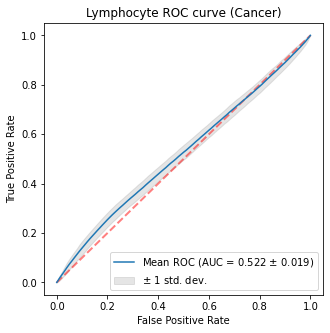

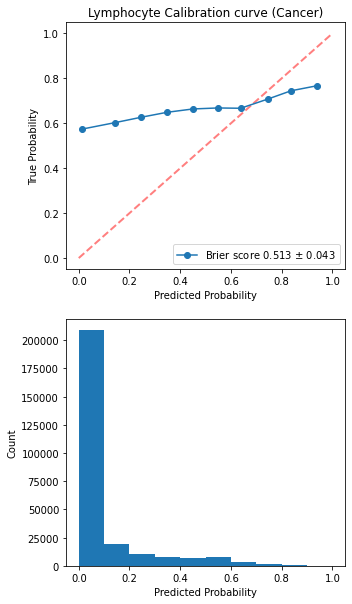

In [49]:
y_trues = []
y_preds = []
for i in range(100):
    i = f'{i:02d}'
    df = pd.read_csv(f'/mnt/data5/output/train/{label}/{i}/cancer_predictions.csv')
    y_trues.append(df[label])
    y_preds.append(df['y_pred'])

plot_roc_curve(y_trues, y_preds, f'{label.title()} ROC curve (Cancer)', f'cancer_{label}_roc_curve.png')
plot_calibration_curve(y_trues, y_preds, f'{label.title()} Calibration curve (Cancer)', f'cancer_{label}_calibration_curve.png')

### Cancer Count

In [10]:
counts = dict()
df = pd.read_csv(f'/mnt/data5/output/tiles/gi-cancer/lymphocyte.csv')
T = ((df['CD3E'] > 0) & (df['PTPRC'] > 0))
B = ((df['MS4A1'] > 0) & (df['PTPRC'] > 0))
plasma = ((df['SDC1'] > 2) & (df['PTPRC'] > 0))
lymphocyte = (T | B | plasma)
counts['T'] = T.sum()
counts['B'] = B.sum()
counts['Plasma'] = plasma.sum()
counts['Lymphocyte'] = lymphocyte.sum()
counts['Total'] = len(df)
counts

{'T': 778, 'B': 97, 'Plasma': 1348, 'Lymphocyte': 1564, 'Total': 2660}

# Model Diagram

In [37]:
label = 'lymphocyte'

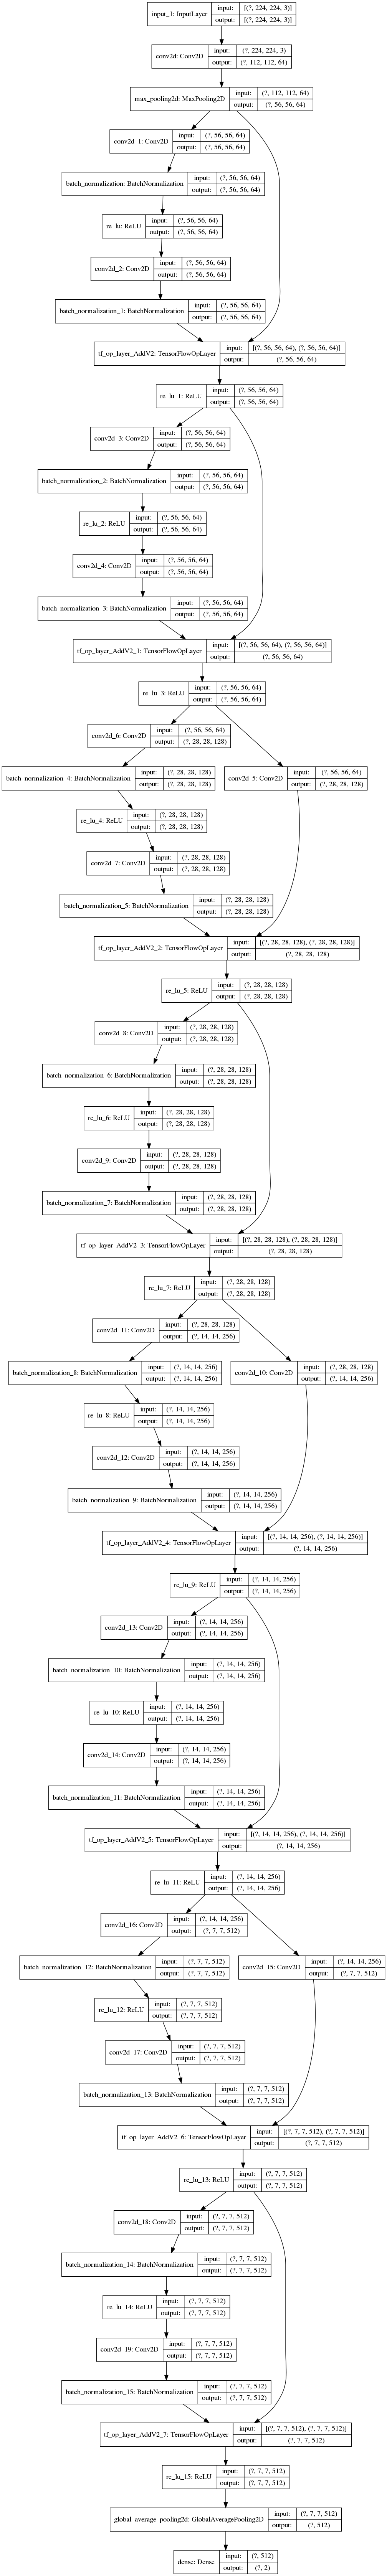

In [38]:
tf.keras.utils.plot_model(
    model,
    to_file=f'{label}_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
)

# Saliency

In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from PIL import Image, ImageDraw
from sklearn.metrics import roc_curve

In [2]:
from steml.utils import config_gpus
config_gpus({0: -1})
import tensorflow as tf

2022-06-29 11:33:49.296488: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-06-29 11:33:50.227148: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-29 11:33:50.499884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-29 11:33:50.504417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-29 11:33:50.504467: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.

In [4]:
trial = '00'
label = 'lymphocyte'

In [5]:
model = tf.keras.models.load_model(f'/mnt/data5/output/train/{label}/{trial}/model.h5')

2022-06-29 11:34:25.735015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-29 11:34:25.770264: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2100000000 Hz
2022-06-29 11:34:25.778123: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f1164a1e40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-29 11:34:25.778178: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-29 11:34:25.940472: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f113521e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-29 11:34:25.

In [8]:
infection = pd.read_csv(f'/mnt/data5/output/train/{label}/{trial}/test.csv')
pred = pd.read_csv(f'/mnt/data5/output/train/{label}/{trial}/test_predictions.csv')
infection['y_pred'] = pred[label]

In [9]:
def binarize(df):
    y_true = df[label]
    y_pred = df['y_pred']
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print(threshold)
    y_bin = (y_pred > threshold).astype(int)
    df['y_bin'] = y_bin
    return df

infection = binarize(infection)

0.23711538


In [10]:
tp = infection[(infection['lymphocyte'] == 1) & (infection['y_bin'] == 1)]
tn = infection[(infection['lymphocyte'] == 0) & (infection['y_bin'] == 0)]
fp = infection[(infection['lymphocyte'] == 0) & (infection['y_bin'] == 1)]
fn = infection[(infection['lymphocyte'] == 1) & (infection['y_bin'] == 0)]

In [26]:
def make_gradcam_heatmap(model, filename, hidden_layer_name, class_idx):
    image = tf.io.decode_png(tf.io.read_file(filename))
    image = tf.image.convert_image_dtype(image, tf.float32)

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(hidden_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        hidden_layer_output, y_pred = grad_model(tf.reshape(image, (1,)+image.shape), training=False)
        class_pred = y_pred[:, class_idx]
    print(class_pred)

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_pred, hidden_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    hidden_layer_output = hidden_layer_output[0]
    heatmap = hidden_layer_output @ pooled_grads[..., tf.newaxis]

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = tf.image.resize(heatmap, image.shape[:2]).numpy()
    heatmap = tf.squeeze(heatmap)
    heatmap = np.uint8(255 * heatmap)

    jet_cm = cm.get_cmap('jet')
    jet_colors = jet_cm(np.arange(256))[:, :3]

    heatmap = jet_colors[heatmap]
    heatmap = np.uint8(255 * heatmap)
    return heatmap

In [98]:
def save_image(filename, heatmap=None, draw_spot=False, alpha=0.4, output_dir=None):
    tile, ext = os.path.splitext(os.path.basename(filename))

    # open tile
    names = [tile]
    im = Image.open(filename)

    # overlay heatmap
    if heatmap is not None:
        names += 'gradcam'
        hm = Image.fromarray(heatmap)
        hm.putalpha(int(256*alpha))
        im.paste(hm, (0, 0), hm)

    # draw spot
    if draw_spot:
        names += 'spot'
        draw = ImageDraw.Draw(im)
        tile_size = 224
        spot_diameter = 86
        lo = tile_size / 2 - spot_diameter / 2
        hi = tile_size / 2 + spot_diameter / 2
        draw.ellipse(xy=(lo, lo, hi, hi), outline=(255,0,0), width=3)

    # save image
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        im.save(os.path.join(output_dir, '_'.join(names) + ext))
    im.show()

In [103]:
filename = tp.sample(1)['path'].iloc[0]
filename

'/mnt/data5/output/tiles/gi-infection/H.pylori/D1/TGCCTAATTGAAGATT-1.png'

In [104]:
heatmap = make_gradcam_heatmap(
    model=model,
    filename=filename,
    hidden_layer_name='conv2d_19',
    class_idx=1,
)

tf.Tensor([0.56342024], shape=(1,), dtype=float32)


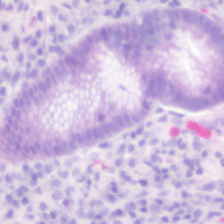

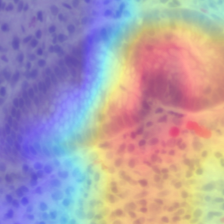

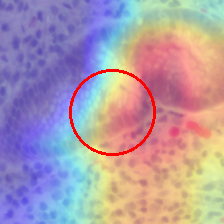

In [105]:
output_dir = None
save_image(filename=filename, output_dir=output_dir)
save_image(filename=filename, output_dir=output_dir, heatmap=heatmap)
save_image(filename=filename, output_dir=output_dir, heatmap=heatmap, draw_spot=True)

# A Reasonable GradCAM?
True Positive Example by Model 00

tf.Tensor([0.5236761], shape=(1,), dtype=float32)


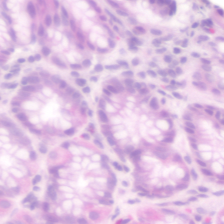

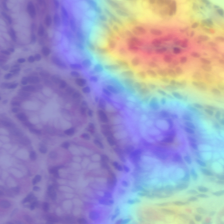

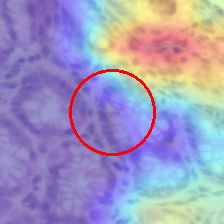

In [87]:
filename = '/mnt/data5/output/tiles/gi-infection/H.pylori/B1/CAGTGTCCGCAGAATG-1.png'
heatmap = make_gradcam_heatmap(
    model=model,
    filename=filename,
    hidden_layer_name='conv2d_19',
    class_idx=1,
)
output_dir = 'reasonable_gradcam'
save_image(filename=filename, output_dir=output_dir)
save_image(filename=filename, output_dir=output_dir, heatmap=heatmap)
save_image(filename=filename, output_dir=output_dir, heatmap=heatmap, draw_spot=True)

# An Unreasonable GradCAM?

tf.Tensor([0.60650915], shape=(1,), dtype=float32)


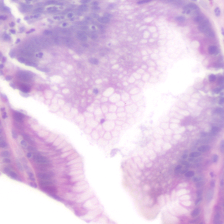

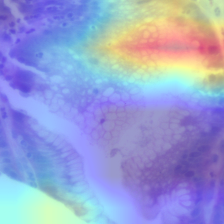

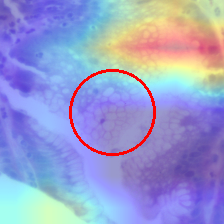

In [91]:
filename = '/mnt/data5/output/tiles/gi-infection/H.pylori/C1/GCCGATTGGCCAAGCT-1.png'
heatmap = make_gradcam_heatmap(
    model=model,
    filename=filename,
    hidden_layer_name='conv2d_19',
    class_idx=1,
)
output_dir = 'unreasonable_gradcam'
save_image(filename=filename, output_dir=output_dir)
save_image(filename=filename, output_dir=output_dir, heatmap=heatmap)
save_image(filename=filename, output_dir=output_dir, heatmap=heatmap, draw_spot=True)